In [1]:

import sys
from matplotlib import pyplot as plt
import numpy
import seaborn as sns
import pandas
from math import log, exp
import numpy as np
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2
import keras.backend as K
from tensorflow import keras
!pip install lifelines
from lifelines.utils import concordance_index

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=60c337f511a328ec57020a8a7dafb04a6b9d0e6f2d68dd87d665813ba8b0779b
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [2]:
def generate_data(treatment_group = False):
    numpy.random.seed(123)
    sd = SimulatedData(5, num_features=9, treatment_group=treatment_group)
    train_data = sd.generate_data(5000, method = 'linear')
    valid_data = sd.generate_data(2000, method = 'linear')
    test_data  = sd.generate_data(2000, method = 'linear')
    return train_data, valid_data, test_data

#Loss Function
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        hazard_ratio = K.exp(y_pred)
        log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
        uncensored_likelihood = y_pred - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood = -K.sum(censored_likelihood)
        return neg_likelihood
    return loss


In [3]:
model = Sequential()
model.add(Dense(17, input_shape=(10,),
                    kernel_initializer=glorot_uniform())) # shape= length, dimension
model.add(Activation('relu'))
model.add(Dense(17, kernel_initializer=glorot_uniform()))
model.add(Activation('relu'))
model.add(Dense(17, kernel_initializer=glorot_uniform()))
model.add(Activation('relu'))
model.add(Dropout(0.375))
model.add(Dense(1, activation="linear",
                    kernel_initializer=glorot_uniform(),
                    kernel_regularizer=l2(0.01),
                    activity_regularizer=l2(0.01)))

### Before running the cells below go to section "Simulate data class" and run it first!

In [6]:
train, valid, test = generate_data(treatment_group=True)

[1. 0. 1. ... 1. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[0. 1. 1. ... 1. 0. 1.]


Training...


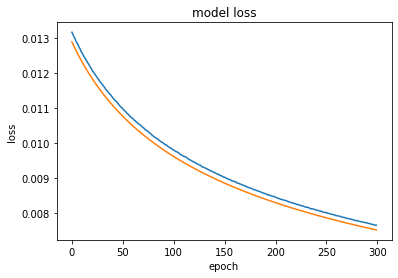

Concordance Index for training dataset: 0.6288701402903061
Concordance Index for test dataset: 0.6163966305816252


In [ ]:
sgd = keras.optimizers.SGD(learning_rate=3e-4, decay=4e-4, momentum=0.9, nesterov=True)
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-5, rho=0.9, epsilon=1e-8)

model.compile(loss=negative_log_likelihood(train['e']), optimizer=sgd)

print('Training...')
history = model.fit(train['x'], batch_size=100, epochs=300, shuffle=False, verbose=False,validation_split=0.2)  # Shuffle False --> Important!!

plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

hr_pred = model.predict(train['x'])
hr_pred = np.exp(hr_pred)

# can be found here: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-in-survival-regression

# nice explanation https://stats.stackexchange.com/questions/478294/how-the-concordance-index-is-calculated-in-cox-model-if-the-actual-event-times-a/478305#478305
ci = concordance_index(train['hr'], -hr_pred, train['e'])

hr_pred2 = model.predict(test['x'])
hr_pred2 = np.exp(hr_pred2)
ci2 = concordance_index(test['hr'], -hr_pred2, test['e'])
print('Concordance Index for training dataset:', ci)
print('Concordance Index for test dataset:', ci2)

### Testing

In [ ]:
!pip install lifelines

In [ ]:
from lifelines.utils import concordance_index
# see here: https://github.com/KITMILTU/DeepSurv-Keras/blob/master/Demo_lifelineExample.ipynb


hr_pred = model.predict(train['x'])
hr_pred = np.exp(hr_pred)

# can be found here: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-in-survival-regression

# nice explanation https://stats.stackexchange.com/questions/478294/how-the-concordance-index-is-calculated-in-cox-model-if-the-actual-event-times-a/478305#478305
ci = concordance_index(train['hr'], hr_pred, train['e'])

hr_pred2 = model.predict(test['x'])
hr_pred2 = np.exp(hr_pred2)
ci2 = concordance_index(test['hr'], hr_pred2, test['e'])
print('Concordance Index for training dataset:', ci)
print('Concordance Index for test dataset:', ci2)


# # Cox Fitting
# cf = CoxPHFitter()
# cf.fit(rossi_dataset, 'week', event_col='arrest')

# cf.print_summary()  # access the results using cf.summary


### SimulateData class

In [4]:
class SimulatedData:
    def __init__(self, hr_ratio,
        average_death = 5,
        censor_mode = 'end_time', end_time = 15, observed_p = None,
        num_features = 10, num_var = 2,
        treatment_group = False):
        """
        Factory class for producing simulated survival data.
        Current supports two forms of simulated data:
            Linear:
                Where risk is a linear combination of an observation's features
            Nonlinear (Gaussian):
                A gaussian combination of covariates
        Parameters:
            hr_ratio: lambda_max hazard ratio.
            average_death: average death time that is the mean of the
                Exponentional distribution.
            censor_mode: the method to calculate whether a patient is censored.
                Options: ['end_time', 'observed_p']
                'end_time': requires the parameter end_time, which is used to censor any patient with death_time > end_time
                'observed_p': requires the parammeter observed_p, which is the percentage of patients with observed death times
            end_time: censoring time that represents an 'end of study'. Any death
                time greater than end_time will be censored.
            num_features: size of observation vector. Default: 10.
            num_var: number of varaibles simulated data depends on. Default: 2.
            treatment_group: True or False. Include an additional covariate
                representing a binary treatment group.
        """

        self.hr_ratio = hr_ratio
        self.censor_mode = censor_mode
        self.end_time = end_time
        self.observed_p = observed_p
        self.average_death = average_death
        self.treatment_group = treatment_group
        self.m = int(num_features) + int(treatment_group)
        self.num_var = num_var

    def _linear_H(self,x):
        """
        Calculates a linear combination of x's features.
        Coefficients are 1, 2, ..., self.num_var, 0,..0]
        Parameters:
            x: (n,m) numpy array of observations
        Returns:
            risk: the calculated linear risk for a set of data x
        """
        # Make the coefficients [1,2,...,num_var,0,..0]
        b = np.zeros((self.m,))
        b[0:self.num_var] = range(1,self.num_var + 1)

        # Linear Combinations of Coefficients and Covariates
        risk = np.dot(x, b)
        return risk

    def _gaussian_H(self,x,
        c= 0.0, rad= 0.5):
        """
        Calculates the Gaussian function of a subset of x's features.
        Parameters:
            x: (n, m) numpy array of observations.
            c: offset of Gaussian function. Default: 0.0.
            r: Gaussian scale parameter. Default: 0.5.
        Returns:
            risk: the calculated Gaussian risk for a set of data x
        """
        max_hr, min_hr = log(self.hr_ratio), log(1.0 / self.hr_ratio)

        # Z = ( (x_0 - c)^2 + (x_1 - c)^2 + ... + (x_{num_var} - c)^2)
        z = np.square((x - c))
        z = np.sum(z[:,0:self.num_var], axis = -1)

        # Compute Gaussian
        risk = max_hr * (np.exp(-(z) / (2 * rad ** 2)))
        return risk

    def generate_data(self, N,
        method = 'gaussian', gaussian_config = {},
        **kwargs):
        """
        Generates a set of observations according to an exponentional Cox model.
        Parameters:
            N: the number of observations.
            method: the type of simulated data. 'linear' or 'gaussian'.
            guassian_config: dictionary of additional parameters for gaussian
                simulation.
        Returns:
            dataset: a dictionary object with the following keys:
                'x' : (N,m) numpy array of observations.
                't' : (N) numpy array of observed time events.
                'e' : (N) numpy array of observed time intervals.
                'hr': (N) numpy array of observed true risk.
        See:
        Peter C Austin. Generating survival times to simulate cox proportional
        hazards models with time-varying covariates. Statistics in medicine,
        31(29):3946-3958, 2012.
        """

        # Patient Baseline information
        data = np.random.uniform(low= -1, high= 1,
            size = (N,self.m))
        self.data = data
        if self.treatment_group:
            data[:,-1] = np.squeeze(np.random.randint(0,2,(N,1)))
            print(data[:,-1])

        # Each patient has a uniform death probability
        p_death = self.average_death * np.ones((N,1))

        # Patients Hazard Model
        # \lambda(t|X) = \lambda_0(t) exp(H(x))
        #
        # risk = True log hazard ratio
        # log(\lambda(t|X) / \lambda_0(t)) = H(x)
        if method == 'linear':
            risk = self._linear_H(data)

        elif method == 'gaussian':
            risk = self._gaussian_H(data,**gaussian_config)

        # Center the hazard ratio so population dies at the same rate
        # independent of control group (makes the problem easier)
        risk = risk - np.mean(risk)

        # Generate time of death for each patient
        # currently exponential random variable
        death_time = np.zeros((N,1))
        for i in range(N):
            if self.treatment_group and data[i,-1] == 0:
                death_time[i] = np.random.exponential(p_death[i])
            else:
                death_time[i] = np.random.exponential(p_death[i]) / exp(risk[i])

        # If Censor_mode is 'observed_p': then find the end time in which observed_p percent of patients have an observed death
        if self.censor_mode is 'observed_p':
            if self.observed_p is None:
                raise ValueError("Parameter observed_p must be porivded if censor_mode is configured to 'observed_p'")
            end_time_idx = int(N * self.observed_p)
            self.end_time = np.sort(death_time.flatten())[end_time_idx]

        # Censor anything that is past end time
        censoring = np.ones((N,1))
        death_time[death_time > self.end_time] = self.end_time
        censoring[death_time == self.end_time] = 0

        # Flatten Arrays to Vectors
        death_time = np.squeeze(death_time)
        censoring = np.squeeze(censoring)

        dataset = {
            'x' : data.astype(np.float32),
            'e' : censoring.astype(np.int32),
            't' : death_time.astype(np.float32),
            'hr' : risk.astype(np.float32)
        }

        return dataset

(array([672., 447., 403., 304., 293., 220., 197., 207., 165., 156., 152.,
        118., 108., 112., 102.,  92.,  80.,  73.,  80.,  61.,  42.,  51.,
         53.,  52.,  36.,  38.,  31.,  29.,  22., 604.]),
 array([2.17224541e-03, 5.02099812e-01, 1.00202739e+00, 1.50195503e+00,
        2.00188255e+00, 2.50181031e+00, 3.00173783e+00, 3.50166535e+00,
        4.00159311e+00, 4.50152063e+00, 5.00144815e+00, 5.50137568e+00,
        6.00130320e+00, 6.50123072e+00, 7.00115871e+00, 7.50108624e+00,
        8.00101376e+00, 8.50094128e+00, 9.00086880e+00, 9.50079632e+00,
        1.00007238e+01, 1.05006514e+01, 1.10005789e+01, 1.15005064e+01,
        1.20004349e+01, 1.25003624e+01, 1.30002899e+01, 1.35002174e+01,
        1.40001450e+01, 1.45000725e+01, 1.50000000e+01], dtype=float32),
 <a list of 30 Patch objects>)

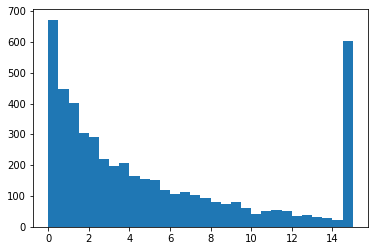

In [7]:
plt.hist(train['t'], bins = 30)

In [9]:
train

{'e': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'hr': array([-0.4809765 ,  0.58408266,  1.6480569 , ...,  0.13061029,
         0.66884357,  0.65649265], dtype=float32),
 't': array([0.14011422, 7.0769086 , 0.57674706, ..., 0.8899516 , 0.1793702 ,
        4.144402  ], dtype=float32),
 'x': array([[ 0.39293838, -0.42772132, -0.5462971 , ...,  0.36965948,
         -0.0381362 ,  1.        ],
        [-0.31364396,  0.45809942, -0.12285551, ..., -0.6490965 ,
          0.06310274,  0.        ],
        [ 0.26880193,  0.69886357,  0.44891065, ..., -0.54347354,
         -0.4125719 ,  1.        ],
        ...,
        [ 0.39394397, -0.12243075, -0.76274157, ..., -0.16138232,
          0.9634465 ,  1.        ],
        [-0.3741995 ,  0.53075767, -0.554963  , ...,  0.7150434 ,
          0.79483634,  0.        ],
        [-0.80517197,  0.74006844, -0.7838531 , ..., -0.72257507,
          0.00230672,  0.        ]], dtype=float32)}